# Homework on two-way fixed effects

*29 September, 2021*

The goal of the following homework is to develop our understanding of two-way fixed effect models. 

Related papers:
 - the original paper by [Abowd, Kramarz, and Margolis](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00020).
 - [Andrews et al paper](https://www.jstor.org/stable/30135090)
 

## Preparing the environment

In [ ]:
using Pkg
Pkg.activate(".") # Create new environment in this folder

# first time you need to install dependencies
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add(["DataFrames","DataFramesMeta","Chain"])
Pkg.add("Plots")
Pkg.add("CategoricalArrays")
Pkg.add("FixedEffectModels")
Pkg.add("RegressionTables")
Pkg.add("Parameters")
Pkg.add("Optim")
Pkg.add("LightGraphs")


In [2]:
# past the first time, you only need to instanciate the current folder
using Pkg
Pkg.instantiate() # Updates packages given .toml file

We then list our imports

In [33]:
using Distributions
using LinearAlgebra
using StatsBase
using DataFrames
using Plots
using Chain
using CategoricalArrays
using FixedEffectModels
using RegressionTables
using Parameters
using Optim
using Optim: converged, maximum, maximizer, minimizer, iterations
using LightGraphs

Base.show(io::IO, ::MIME"text/latex", df::AbstractDataFrame) = show(df, backend=:html, show_row_number=true, highlighters=:tf_html_default )
ENV["GRDIR"]=""
Pkg.build("GR")

    Building GR → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/c2178cfbc0a5a552e16d097fae508f2024de61a3/build.log`


## Constructing Employer-Employee matched data

### Create a mobility matrix

One central piece is to have a network of workers and firms over time. We start by simulating such an object. The rest of the homework will focus on adding wages to this model. As we know from the lectures, a central issue of the network will be the number of movers.

We are going to model the mobility between workers and firms. Given a transition matrix we can solve for a stationary distribution, and then construct our panel from there.

In [5]:
mutable struct parameters
    α_sd::Float64 
    ψ_sd::Float64 
    csort::Float64  # Sorting effect
    cnetw::Float64  # Network effect
    csig::Float64   # Cross-sectional standard deviation
    w_sigma::Float64
end

mutable struct types
    nk::Int     # approximate each distribution with some points of support
    nl::Int     # Let's assume moving probability is fixed
    λ::Float64 
    nt::Int
    ni::Int
end


In [6]:
p = parameters(1.0,1.0,0.5,0.2,0.5,0.2)
q = types(30,10,0.1, 10, 10000)

types(30, 10, 0.1, 10, 10000)

In [7]:
function transition_m(p::parameters, q::types)
    α_sd = p.α_sd; ψ_sd = p.ψ_sd; csort = p.csort; cnetw = p.cnetw; csig = p.csig;
    nk = q.nk; nl = q.nl; λ = q.λ; 

    ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
    α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

    # Let's create type-specific transition matrices
    # We are going to use joint normals centered on different values
    G = zeros(nl, nk, nk)
    for l in 1:nl, k in 1:nk
        G[l, k, :] = pdf(Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
        G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
    end

    # We then solve for the stationary distribution over psis for each alpha value
    # We apply a crude fixed point approach
    H = ones(nl, nk) ./ nk
    for l in 1:nl
        M = transpose(G[l, :, :])
        for i in 1:100
            H[l, :] = M * H[l, :]
        end
    end
    return α, ψ, G,H
end


transition_m (generic function with 1 method)

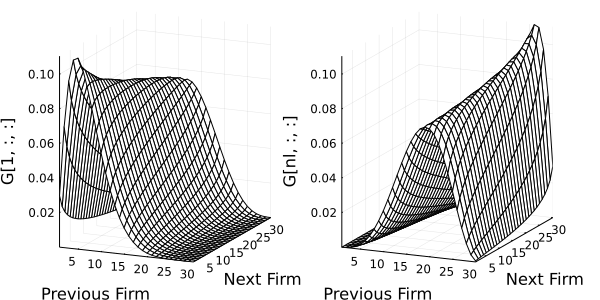

In [8]:
α, ψ, G, H = transition_m(p,q)
p1 = plot(G[1, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[1, :, :]", st=:wireframe)
p2 = plot(G[q.nl, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[nl, :, :]", st=:wireframe, right_margin=10Plots.mm) # right_margin makes sure the figure isn't cut off on the right
plot(p1, p2, layout=(1, 2), size=[600,300])

And we can plot the joint distribution of matches

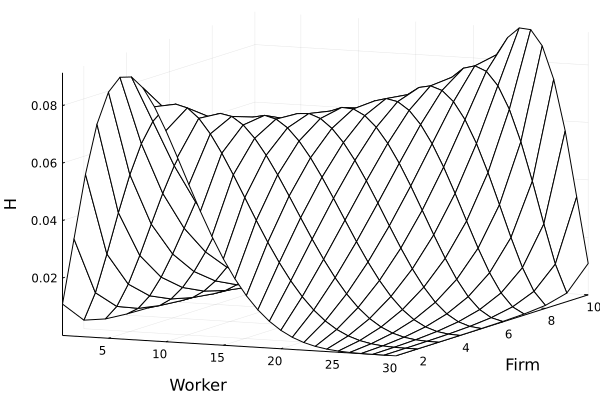

In [9]:
plot(H, xlabel="Worker", ylabel="Firm", zlabel="H", st=:wireframe)

<span style="color:green">Question 1</span>

 - Explain what the parameters `cnetw` and  `csort` do.


`cnet` makes the mean of the transition distribution of the new firm increasing in the current firm. So, workers from firms with `k` are more likely to go to a firm with higher `k`. Worker form the `k=1` firm go to the mean firm on average.

`csort` ensures that the high ability workers go to high ability firms. Subtracting `csort*l` essentially shifts the pdf to the right, so a high `l` worker would more likely go to a high `k` firm. 

### Simulate a panel

The next step is to simulate our network given our transition rules.

In [10]:
function simulate_panel(p::parameters, q::types, α::Array{Float64,1}, ψ::Array{Float64,1}, G::Array{Float64, 3}, H::Array{Float64,2})
    α_sd = p.α_sd; ψ_sd = p.ψ_sd; csort = p.csort; cnetw = p.cnetw; csig = p.csig;
    nk = q.nk; nl = q.nl; λ = q.λ; ni = q.ni; nt = q.nt;
    
    # We simulate a balanced panel
    ll = zeros(Int64, ni, nt) # Worker type
    kk = zeros(Int64, ni, nt) # Firm type
    spellcount = zeros(Int64, ni, nt) # Employment spell

    for i in 1:ni
        
        # We draw the worker type
        l = rand(1:nl)
        ll[i,:] .= l
        
        # At time 1, we draw from H
        kk[i,1] = sample(1:nk, Weights(H[l, :]))
        
        for t in 2:nt
            if rand() < λ
                kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
                spellcount[i,t] = spellcount[i,t-1] + 1
            else
                kk[i,t] = kk[i,t-1]
                spellcount[i,t] = spellcount[i,t-1]
            end
        end
        
    end

    # Attach Firm ID to types
    # The final step is to assign identities to the firms. We are going to do this is a relatively simple way, by simply randomly assigning firm ids to spells.
    firms_per_type = 15
    jj = zeros(Int64, ni, nt) # Firm identifiers

    draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

    for i in 1:ni
        
        # extract firm type
        k = kk[i,1]
        
        # We draw the firm (one of firms_per_type in given group)
        jj[i,1] = draw_firm_from_type(k)
        
        for t in 2:nt
            if spellcount[i,t] == spellcount[i,t-1]
                # We keep the firm the same
                jj[i,t] = jj[i,t-1]
            else
                # We draw a new firm
                k = kk[i,t]
                
                new_j = draw_firm_from_type(k)            
                # Make sure the new firm is actually new
                while new_j == jj[i,t-1]
                    new_j = draw_firm_from_type(k)
                end
                
                jj[i,t] = new_j
            end
        end
    end

    # Make sure firm ids are contiguous
    contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
    jj .= getindex.(Ref(contiguous_ids),jj);

    # Construct DataFrame
    ii = repeat(1:ni,1,nt)
    tt = repeat((1:nt)',ni,1)
    df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);
    return df
end

simulate_panel (generic function with 1 method)

<span style="color:green">Question 2</span>

 - Explain the last 2 lines, in particular `.=>` and the use of `Ref`. 

When we randomly assign firmm id's we can get any collection of firm ids with random numbers in it. The code first maps each firm id into an element of contiguous vector $\{ x_n : n \in \{1,2,..N\} \}$ where $N$ is the number of unique firms. `.=>` does this operation element wise for each unique firm id after random assignment. The assignment to contiguous numbers is done refering back to the dictionary. Here again `getindex` and `Ref` allow to perform the operation element-wise instead of running a for loop. 

In [11]:
df = simulate_panel(p,q,α,ψ,G,H)

,i,j,l,k,α,ψ,t,spell
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64
1,1,1,9,16,0.908458,0.0404405,1,0
2,2,2,5,8,-0.114185,-0.649324,1,0
3,3,3,10,19,1.33518,0.286894,1,0
4,4,4,6,19,0.114185,0.286894,1,0
5,5,5,9,19,0.908458,0.286894,1,0
6,6,6,9,6,0.908458,-0.864894,1,0
7,7,7,1,4,-1.33518,-1.13098,1,0
8,8,8,5,20,-0.114185,0.372289,1,0
9,9,9,7,14,0.348756,-0.121587,1,0


<span style="color:green">Question 3</span>

Use `Chain.jl` and `DataFramesMeta.jl` to computer:

 - mean firm size, in the crossection, expect something like 15.
 - mean number of movers per firm in total in our panel.


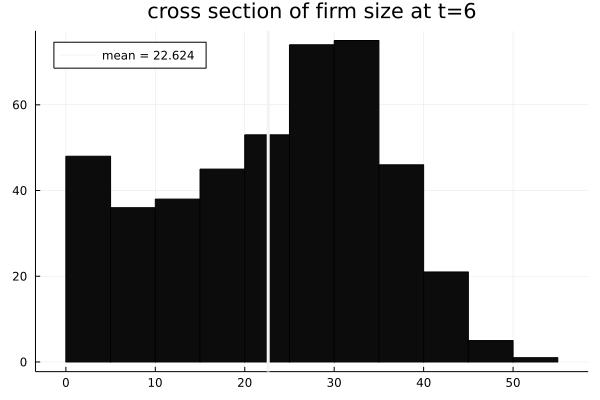

In [35]:
df_workers = @chain df begin
    groupby([:j, :t])
    combine(:i => length ∘ unique => :workers)
    filter(:t => ==(6), _)
  end

  histogram(df_workers.workers,  palette = :grays, label = "")
  mean_workers = round(mean(df_workers.workers), digits = 3)
  vline!([mean_workers], linewidth = 3, label = "mean = $mean_workers", palette = :grays, legend = :topleft)
  title!("cross section of firm size at t=6")

In [36]:
df_movers = @chain df begin
    groupby([:i])
    combine(:j => length ∘ unique => :firms)
  end

df = leftjoin(df, df_movers, on = :i);

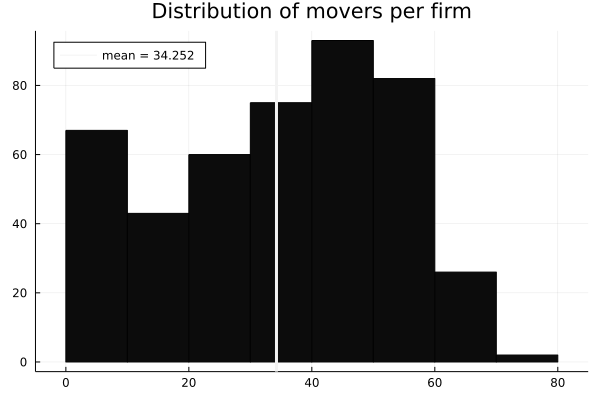

In [37]:

movers_per_firm  = @chain df begin
  filter(:firms => >(1), _)
  groupby([:j])
  combine(:i => length ∘ unique => :movers)
end

histogram(movers_per_firm.movers,  palette = :grays, label = "")
mean_movers = round(mean(movers_per_firm.movers), digits = 3)
vline!([mean_movers], linewidth = 3, label = "mean = $mean_movers", palette = :grays, legend = :topleft)
title!("Distribution of movers per firm")


## Simulating AKM wages and create Event Study plot

We start with just AKM wages, which is log additive with some noise.

In [38]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

<span style="color:green">Question 4</span>

Before we finish with the simulation code. Use this generated data to create the event study plot from [Card. Heining, and Kline](https://doi.org/10.1093/qje/qjt006):

1. Compute the mean wage within firm
2. Group firms into quartiles
3. Select workers around a move (2 periods pre, 2 periods post)
4. Compute wages before/after the move for each transition (from each quartile to each quartile)
5. Plot the lines associated with each transition

In [39]:
function split_str(str::String, i::Int64)
    str = split(str, ":")[i]
    return string(str)
end

split_str (generic function with 1 method)

In [40]:
avg_wage  = @chain df begin
    groupby([:j, :t])
    combine(:lw => mean => :mean_wage_j)
  end

  transform!(groupby(avg_wage, :t), :mean_wage_j => x -> (cut(x,4)))
  avg_wage[!,:quartile] = split_str.(string.(avg_wage.mean_wage_j_function),1);

  df = leftjoin(df, avg_wage, on = [:j, :t]);


In [43]:
lag_firm = zeros(Int64, q.ni*q.nt)
sort!(df, [:i,:t])
for i in 1:q.ni
    sub_df = df[df.i .== i,:]
    k = ((i-1)*10) + 1
    lag_firm[k] = sub_df.j[1]
    lag_firm[(k+1):(k+9)] = sub_df.j[1:end-1]
end

df[!,:lag_j] = lag_firm ;

function moves(j, lag_j)
    if (j == lag_j)
        move = "No"
    else
        move = "Yes"
    end
    return move
end

df[!, :move] = moves.(df.j, df.lag_j)
mover_times = select( df[df.move .== "Yes",:], [:i, :t])
rename!(mover_times, :t => :t_period_of_move) ;
df = leftjoin(df, mover_times, on = [:i])


,i,j,l,k,α,ψ,t,spell,firms,lw
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Int64?,Float64
1,5,5,9,19,0.908458,0.286894,1,0,2,1.42025
2,5,5,9,19,0.908458,0.286894,2,0,2,1.49787
3,5,5,9,19,0.908458,0.286894,3,0,2,1.30196
4,5,5,9,19,0.908458,0.286894,4,0,2,1.20327
5,5,5,9,19,0.908458,0.286894,5,0,2,1.11253
6,5,318,9,24,0.908458,0.752729,6,1,2,1.56958
7,5,318,9,24,0.908458,0.752729,7,1,2,1.71465
8,5,318,9,24,0.908458,0.752729,8,1,2,1.68761
9,5,318,9,24,0.908458,0.752729,9,1,2,1.4439


keep moves with two periods before and after in the same firm

In [45]:
search_term = ["No", "No", "Yes", "No", "No"]
mover_ids_with_five_periods = DataFrame(i = Int[], t_spell_beginning = Int[])
for i in 1:q.ni
    for j in 1:5
    sub_df = df[df.i .== i,:][j:j+4,:]
        if (sum(sub_df.move .== search_term) == 5)
            push!(mover_ids_with_five_periods, [i,j])
            break
        end
    end
end



In [50]:
movers_for_plot = leftjoin(mover_ids_with_five_periods, df, on = :i)
movers_for_plot.τ = movers_for_plot.t .- movers_for_plot.t_period_of_move;
movers_final = movers_for_plot[movers_for_plot.t_period_of_move .< 9,:]
movers_final = movers_final[movers_final.τ .> -3,:]
movers_final = movers_final[movers_final.τ .< 2,:]
select(movers_final, [:i, :j, :t, :t_spell_beginning, :t_period_of_move, :τ, :quartile])

,i,j,t,t_spell_beginning,t_period_of_move,τ,quartile
,Int64,Int64?,Int64?,Int64,Int64?,Int64,String?
1,5,5,4,4,6,-2,Q3
2,5,5,5,4,6,-1,Q3
3,5,318,6,4,6,0,Q4
4,5,318,7,4,6,1,Q4
5,8,8,1,3,2,-1,Q3
6,8,169,2,3,2,0,Q2
7,8,169,3,3,2,1,Q2
8,8,169,3,3,5,-2,Q2
9,8,169,4,3,5,-1,Q2


In [51]:
pre_change = select(movers_final[movers_final.τ .== -1,:] , [:i, :quartile])
rename!(pre_change, :quartile => :pre_quartile)
movers_final = leftjoin(movers_final, pre_change, on = :i)

post_change = select(movers_final[movers_final.τ .== 0,:] , [:i, :quartile])
rename!(post_change, :quartile => :post_quartile)
movers_final = leftjoin(movers_final, post_change, on = :i)

select(movers_final, [:i, :j, :t, :τ, :pre_quartile, :post_quartile])



,i,j,t,τ,pre_quartile,post_quartile
,Int64,Int64?,Int64?,Int64,String?,String?
1,5,5,4,-2,Q3,Q4
2,5,5,5,-1,Q3,Q4
3,5,318,6,0,Q3,Q4
4,5,318,7,1,Q3,Q4
5,8,8,1,-1,Q3,Q2
6,8,169,2,0,Q3,Q2
7,8,169,3,1,Q3,Q2
8,8,169,3,-2,Q3,Q2
9,8,169,4,-1,Q3,Q2


In [52]:
for_plot  = @chain movers_final begin
    groupby([:τ, :pre_quartile, :post_quartile])
    combine(:lw => mean => :mean_wage)
  end

,τ,pre_quartile,post_quartile,mean_wage
,Int64,String?,String?,Float64
1,-2,Q3,Q4,1.3267
2,-1,Q3,Q4,1.31191
3,0,Q3,Q4,1.58216
4,1,Q3,Q4,1.55518
5,-1,Q3,Q2,0.207953
6,0,Q3,Q2,-0.0132355
7,1,Q3,Q2,-0.00682382
8,-2,Q3,Q2,0.205751
9,-1,Q2,Q2,-0.616544


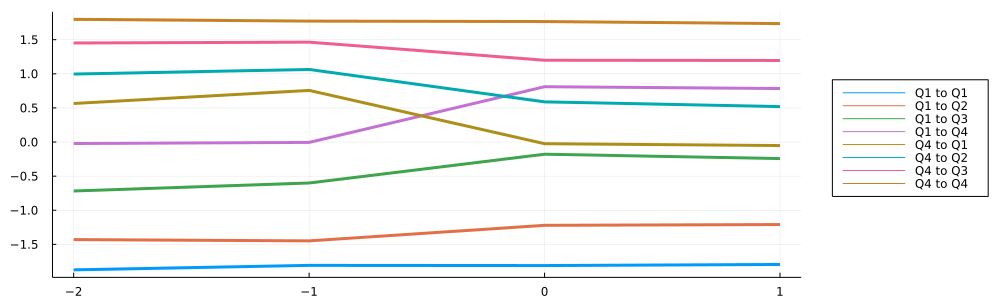

In [53]:
event_plot = plot()
for q1 in ["Q1", "Q4"], q2 in ["Q1", "Q2", "Q3", "Q4"]
    dff = for_plot[(for_plot.pre_quartile .== q1) .& (for_plot.post_quartile .== q2),:]
    sort!(dff,:τ)
    event_plot = plot!(dff.τ , dff.mean_wage, label = "$q1 to $q2", legend = :outerright, size = (1000,300), linewidth = 3)
end
event_plot

## Calibrating the parameters

<span style="color:green">Question 5</span>

 - Pick the parameters `psi_sd`, `alpha_sd`, `csort`, `csig`, and `w_sigma` to roughly match the decomposition in the Card-Heining-Kline paper (note that they often report numbers in standard deviations, not in variances).

In [12]:
function variances(p::parameters, q::types)
    α, ψ, G, H = transition_m(p,q)
    df = simulate_panel(p,q,α,ψ,G,H)
    df[!, :lw] = df.α + df.ψ + p.w_sigma * rand(Normal(), size(df)[1]);

    # Compute variances
    var_α = var(df.α)
    var_ψ = var(df.ψ)  
    cov_αψ = 2*cov(df.α,df.ψ)
    var_Yit = var(df.lw)

    results = [var_Yit, var_α, var_ψ, cov_αψ ]
    return results
end

variances (generic function with 1 method)

In [27]:
objective(p::parameters) = variances(p,q)

function f(x)
    p = parameters(x[1], x[2], x[3], 0.2, x[4], 0.2)
    y = objective(p)
    println(y)
    CHK = [0.137, 0.084, 0.025, 0.003]
    dist  = sum((y .- CHK).^2)
    return dist
end

f (generic function with 1 method)

In [ ]:
x_iv = [1, 1, 0.01, 0.01]
results = optimize(f, x_iv, LBFGS()) 

In [30]:
p_matched = parameters(0.7029221020639402, 0.6106460412455095, 0.0016349861948870106, 0.2,  0.05098130214935575, 0.2)

objective(p_matched)

4-element Vector{Float64}:
 0.27467473881812304
 0.23137226663652377
 0.002678056317738856
 0.0007082404404618696

## Estimating two-way fixed effects

This requires first extracting the large set of firms connected by movers, and then estimating the linear problem with many dummies.

### Extracting the connected set

Because we are not going to deal with extremely large data-sets, we can use off-the-shelf algorithms to extract the connected set. Use the function `connected_components` from the package `LightGraphs` to extract the connected set from our data. To do so you will need to first construct an adjacency matrix between the firms. 

<span style="color:green">Question 6</span>

 - Extract the connected set and drop firms not in the set (I expect that all firms will be in the set).

In [57]:
α, ψ, G, H = transition_m(p,q)
df = simulate_panel(p,q,α,ψ,G,H)
df[!, :lw] = df.α + df.ψ + p.w_sigma * rand(Normal(), size(df)[1]);
df

,i,j,l,k,α,ψ,t,spell,lw
,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Float64
1,1,1,7,24,0.348756,0.752729,1,0,0.928818
2,2,2,7,16,0.348756,0.0404405,1,0,0.431719
3,3,3,7,10,0.348756,-0.460495,1,0,-0.146047
4,4,4,7,18,0.348756,0.203544,1,0,0.316815
5,5,5,2,15,-0.908458,-0.0404405,1,0,-0.520428
6,6,6,5,21,-0.114185,0.460495,1,0,0.659542
7,7,7,2,13,-0.908458,-0.203544,1,0,-1.33775
8,8,8,6,14,0.114185,-0.121587,1,0,-0.164561
9,9,9,10,12,1.33518,-0.286894,1,0,0.77926


In [60]:
nj = length(unique(df.j))
adjacency_matrix = zeros(Int, nj, nj);

In [71]:
for a in unique(df.j), b in unique(df.j)
  subdf_a = df[df.j .== a,:]
  subdf_b = df[df.j .== b,:]

  if isempty(intersect(subdf_a.i, subdf_b.i)) == false
    adjacency_matrix[a,b] = 1
  else
    adjacency_matrix[a,b] = 0
  end
end


In [75]:
g = SimpleGraph(adjacency_matrix);
cc = connected_components(g)

2-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  436, 437, 438, 439, 440, 441, 442, 443, 444, 445]
 [406]

### Estimating worker and firm FEs

This part of the problem set is for you to implement the AKM estimator. As discussed in class, this can be done simply by updating, in turn, the worker FE and the firm FE.

Start by appending 2 new columns `alpha_hat` and `psi_hat` to your data. Then loop over the following:

1. Update `alpha_hat` by taking the mean within `i` net of firm FE
2. Update `psi_hat` by taking the mean within `fid` net of worker FE

<span style="color:green">Question 7</span>

 - Run the previous steps in a loop, and at each step evaluate how much the total mean square error has changed. Check that is goes down with every step. Stop when the MSE decreases by less than 1e-9.


Note that you can increase speed by focusing on movers only first.



In [113]:
function estimation(df::DataFrame)
    df[!,:alpha_hat] .= 0;
    df[!,:psi_hat] .= 0;
    mse = zeros(Float64, 1000);

    for i in 2:1000
        transform!(x -> mean(x.lw - x.psi_hat) , groupby(df, [:i]) )
        df.alpha_hat = df. x1;
        transform!(x -> mean(x.lw - x.alpha_hat) , groupby(df, [:j]) )
        df.psi_hat = df. x1;
        mse[i] = mean((df.lw .- df.alpha_hat .- df.psi_hat).^2)
        if ((mse[i] - mse[i-1]) < 1e-9)
            break
        end
    end 
    return df
end


estimation (generic function with 1 method)

In [ ]:
df = estimation(df);
select(df, [:i, :j, :t, :α  , :ψ, :alpha_hat, :psi_hat ])

In [116]:
λ_values = [0.1, 0.3, 0.5, 0.7, 0.9]

5-element Vector{Float64}:
 0.1
 0.3
 0.5
 0.7
 0.9

## Limited mobility bias

We now have everything we need to look at the impact of limited mobility bias. Compute the following:

1. Compute the estimated variance of firm FE
2. Do it for varying levels of mobility λ. For each the number of movers, collect the actual variance and the estimated variance. Run it for different panel lengths: 5, 6, 8, 10, 15.

<span style="color:green">Question 8</span>

 - Report this in a plot. This should look like the [Andrews et al.](https://www.sciencedirect.com/science/article/pii/S0165176512004272) plot.

In [ ]:
var_ψ_hat = var(df.psi_hat)

## Correcting the bias

<span style="color:green">Question 9</span>

 - Implement both the exact as well as the approximated (Hutchkinson trace approximation) Andrews et al. type fixed-effect bias correction based on homoskedacity. Redo the plot from Question 6 so that it includes these 2 estimates.

## Evidence of learning

<span style="color:green">Question 10</span>

 - Regress the wage of a worker at time $t$ on his wage at time $t-l$ and the average wage of his co-workers at time $t-l$ for some lags $l$ focusing on workers that did change firms between $t-l$ and $t$. 
 - Comment on the result.
